## PyTorch DNN
- torch.utils.data 데이터셋의 표준 정의 및 데이터셋 불러오고 자르거나 섞는데 쓰는 도구 모듈
- torch.utils.data.Dataset 학습에 필요한 데이터셋 모듈
    - torchvision.datases 상속 및 이미지 데이터셋 모음
- torch.utils.data.DataLoader 학습에 필요한 데이터 로딩해주는
- torchvision.transforms 
    - 이미지 데이터셋에 쓸 수 있는 여러가지 변환 필터를 담고 있는 모듈
    - 텐서 변환, 크기 조절, 크롭, 밝기, 대비 조절 등
- torchvision.utils : 이미지 데이터 저장 및 시각화 위한 도구 모듈

## Fashion MNIST
- 0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'


In c:\users\urse\anaconda3\envs\untitled\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\users\urse\anaconda3\envs\untitled\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\users\urse\anaconda3\envs\untitled\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In c:\users\urse\anaconda3\envs\untitled\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\users\urse\anaconda3\envs\untitled

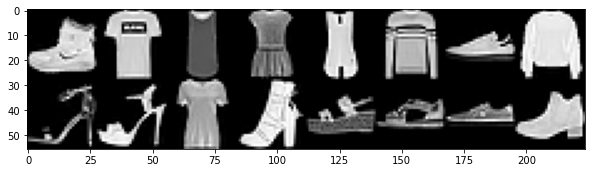

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])


In [1]:
from torchvision import datasets, transforms, utils
from torch.utils import data

import matplotlib.pyplot as plt
import numpy as np

# Fashion MNIST Classes
CLASSES = {
    0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'
}


# 단계1) transform 설정 (이미지 로드시 변환 도구)
# 입력을 변환시켜주는 도구
transform = transforms.Compose([
    transforms.ToTensor() # 이미지를 파이토치 텐서로 변환
    # transforms.Resize() # 이미지 크기 조정
    # transforms.Normalizae () 
    # transforms.RandomHorizontalFlip : 무작위 오른쪽 왼쪽 뒤집기
    # RandomCrop : 이미지를 무작위로 자르는 기능
])

# 단계2) train, test data 설정 및 transform 객체 연결
trainset = datasets.FashionMNIST(
    root = 'data/', 
    train = True, 
    download = True, # 데이터셋 다운로드
    transform = transform
)

testset = datasets.FashionMNIST(
    root = 'data/',
    train = False,
    download = True,
    transform = transform
)

# 단계3) 데이터 로더 준비 (batch size 설정)
batch_size = 16
train_loader = data.DataLoader(
    dataset = trainset,
    batch_size = batch_size
)

test_loader = data.DataLoader(
    dataset = testset,
    batch_size = batch_size
)

# 단계4) data 가져오기, for문 사용가능, iter사용가능
dataiter = iter(train_loader)
images, labels = next(dataiter)

# visualiztaion
def visualization(images, labels):
    # utils의 makergrid 함수로 grid 만들어주기
    img = utils.make_grid(images, padding=0) # 가져온 image들 grid 형태로 만들어줌
    npimg = img.numpy()
    plt.figure(figsize=(10,7))
    plt.imshow(np.transpose(npimg, (1,2,0))) # matplotlib 호환을 위한 tranpose
    plt.show()
    
# image 시각화해보기
visualization(images, labels)
print(labels)


In [2]:
len(train_loader)

3750

## DNN 으로 패션 아이템 분류하기

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # nn 모듈의 함수 버전
from torchvision import transforms, datasets # torchvision dataset 다루기 위한

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(USE_CUDA, DEVICE)

epochs = 30
batch_size = 64

## 모델 설계
# fc layer1 : 784 -> 256 
# fc layer2 : 256 -> 128
# fc layer3 : 128 -> 10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 학습 함수
def train(model, train_loader, optimizer):
    model.train()

    for batch_idx, (data,target) in enumerate(train_loader):
        # 학습 데이터를 DEVICE의 메모리로 보냄
        data, target = data.to(DEVICE), target.to(DEVICE)

        # 반복 때마다 기울기를 새로 계산하므로, optimizer.zero_grad() 함수 호출
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step() # step() 함수는 계산한 기울기를 앞서 정의한 알고리즘에 맞추어 가중치를 수정
    
    
# 평가때는 기울기를 계산하지 않음
def evaluate(model, test_loader):
    model.eval() # 평가 모드로 모델 변경
    test_loss = 0 # 테스트 오차
    correct=0 # 예측이 맞은 수
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE) # test data, target DEVICE 로 전송
            output = model(data) 
            
            # 교차엔트로피시 미니배치의 합을 받아와야 함.
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # item() 함수 - 1개의 값을 가진 텐서의 값을 가져옴
        
            pred = output.max(1, keepdim=True)[1] # 가장 큰 확률 값을 가진 값 예측 -> 가장 큰 값과, 해당 값의 index 반환 -> index 사용
            correct += pred.eq(target.view_as(pred)).sum().item() # view_as => target을 pred의 shape처럼 바꿔줌 / sum().item() => 맞춘갯수의 합

    # 정확도 구하기
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, test_accuracy


False cpu


In [16]:
## dropout, augmnetation 추가 전
# to 함수는 모델의 파라미터들을 지정한 장치의 메모리로 보냄
model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01)


# 실제 학습 진행
for epoch in range(1, epochs+1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))

[1] Test Loss: 0.5660, Accuracy: 80.24%
[2] Test Loss: 0.4949, Accuracy: 82.35%
[3] Test Loss: 0.4582, Accuracy: 83.71%
[4] Test Loss: 0.4305, Accuracy: 84.68%
[5] Test Loss: 0.4088, Accuracy: 85.45%
[6] Test Loss: 0.3933, Accuracy: 86.02%
[7] Test Loss: 0.3827, Accuracy: 86.36%
[8] Test Loss: 0.3736, Accuracy: 86.58%
[9] Test Loss: 0.3675, Accuracy: 86.92%
[10] Test Loss: 0.3606, Accuracy: 87.07%
[11] Test Loss: 0.3560, Accuracy: 87.32%
[12] Test Loss: 0.3517, Accuracy: 87.37%
[13] Test Loss: 0.3473, Accuracy: 87.62%
[14] Test Loss: 0.3440, Accuracy: 87.82%
[15] Test Loss: 0.3417, Accuracy: 87.82%
[16] Test Loss: 0.3394, Accuracy: 87.97%
[17] Test Loss: 0.3387, Accuracy: 88.02%
[18] Test Loss: 0.3360, Accuracy: 88.07%
[19] Test Loss: 0.3369, Accuracy: 88.11%
[20] Test Loss: 0.3344, Accuracy: 88.12%
[21] Test Loss: 0.3332, Accuracy: 88.26%
[22] Test Loss: 0.3330, Accuracy: 88.21%
[23] Test Loss: 0.3329, Accuracy: 88.29%
[24] Test Loss: 0.3327, Accuracy: 88.46%
[25] Test Loss: 0.3334, A

In [30]:
from torchsummary import summary
summary(model, (1, 784))
#print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
            Linear-2                  [-1, 128]          32,896
            Linear-3                   [-1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.90
Estimated Total Size (MB): 0.90
----------------------------------------------------------------
